<a href="https://colab.research.google.com/github/ivychung/plant-ML/blob/k-fold-cross-validation/tomato_10_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# File Name : tomato_10_classes.ipynb
#
# Creation Date : Feburary 22, 2022
#
# Created By : Ivy Chung and Anoushka Gupta
# ========================================

"""Initializing required libraries"""

# so that we can mount google drive
from google.colab import drive

# numerical computation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc # garbage collector to free objects on demand

# file manipulation
import zipfile
import os
import shutil

# load and show images with Pillow
from PIL import Image

# load and display an image with Matplotlib
%matplotlib inline
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold

# tensorflow tools
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# other
import cv2

from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the dataset zip file
dataset_name = 'PlantVillage'
drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/dataset/'
working_dataset_address = os.path.join('/tmp/', dataset_name)

zip_ref = zipfile.ZipFile(drive_dataset_address + dataset_name + '.zip', 'r')
zip_ref.extractall('/tmp/') # Extracts the files into the appropriate folder
zip_ref.close()

In [ ]:
# Removes the __MACOSX file that comes with zipping a file on Mac
try:
  shutil.rmtree('/tmp/__MACOSX')
except:
  pass

In [ ]:
# Function to extract all sub- file/directory names
def read_filenames(dir_path, file_bool = True):
  if file_bool: # list all files in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isfile(os.path.join(dir_path, f))]
  if not file_bool: # list all subfolders in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isdir(os.path.join(dir_path, f))]


In [ ]:
# getting classes
classes = read_filenames(working_dataset_address,file_bool = False)

# global variables to keep track of how many classes we have
CLASS_SIZE = len(classes)

classes

['Tomato_Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Bacterial_spot',
 'Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Tomato_Septoria_leaf_spot']

In [ ]:
# Collect all image names
img_names = [read_filenames(os.path.join(working_dataset_address, classes[i])) for i in range(CLASS_SIZE)]

# Row length should be the number of classes
print("Row Length", len(img_names))

# collect each column length
row_lengths = []
for i in range(CLASS_SIZE):
  row_lengths.append(len(img_names[i]))

print("Column length", row_lengths)

Row Length 10
Column length [1909, 373, 1404, 1591, 3209, 1676, 2127, 952, 1000, 1771]


Original image details
JPEG
(256, 256)
RGB

Image in pixel values
<class 'numpy.ndarray'>
(256, 256, 3) 



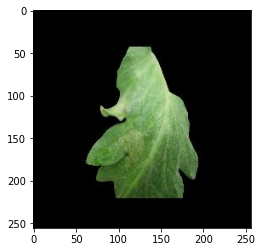


Tomato_Late_blight


In [ ]:
# checking image processing with one image
img_path = os.path.join(working_dataset_address, classes[0], img_names[0][1])

# reading the image
image = Image.open(img_path)

# summarize original image details
print("Original image details")
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array of pixel values
data = asarray(image)

# summarize converted image details
print("\nImage in pixel values")
print(type(data))
print(data.shape, "\n")

plt.imshow(data)
plt.show()
print("\n" + classes[0])

In [ ]:
# making a np array of the images in pixel values
x = []
y = []

for i in range(CLASS_SIZE):
  for j in range(len(img_names[i])):
    img_path = os.path.join(working_dataset_address, classes[i], img_names[i][j])
    try:
      img = Image.open(img_path)
      data = asarray(img) # convert image to numpy array
      x.append(data)
      y.append(classes[i])
    except:
      pass

image_count = len(x)
print("Total image count:", image_count)
x = np.asarray(x)
y = np.asarray(y)

Total image count: 16011
Label is the one expected:  True
Equal amount of responses and predictors:  True 



In [ ]:
# convert our data vectors to the desired format
# Our x data vectors are four-dimensional, just as we wanted

# convert the labels be to int-encoded 
label_encoder = LabelEncoder()

# functino to convert y data vectors to one-hot encoding class matrices
def convert_to_categorical(y_train, y_test):
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)

  y_train = keras.utils.to_categorical(y_train, CLASS_SIZE)
  y_test = keras.utils.to_categorical(y_test, CLASS_SIZE)

  return y_train, y_test

In [ ]:
# Model implementing CNN layers
# Activation functions used: relu and softmax
# Do Conv2D, flatten and dropout (to deal with overfitting)
# num_classes = number of nodes

def create_model():
  model = keras.Sequential(
      [  
          Input(shape=x_train.shape[1:]),
          Conv2D(32, kernel_size=(3, 3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(64, kernel_size=(3, 3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dropout(0.5),
          Dense(CLASS_SIZE, activation='softmax'),
      ],
      'CNN'
  )
  return model

In [ ]:
# use callback to find the optimal number of epochs to use
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


In [ ]:
# To perform k-fold cross-validation, we need to split the data into k-1 training sets and one test set

# Storing the average of all predictions
data_kfold = pd.DataFrame()

N_SPLIT = 10
# 128 and 256 has the best batch size results
BATCH_SIZE = 128
MAX_EPOCH = 10

# Using stratified k fold because of our imbalance dataset
kfold = StratifiedKFold(n_splits = N_SPLIT, random_state = 1, shuffle = True)

j=0
for train_index, test_index in kfold.split(x,y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

  y_train, y_test = convert_to_categorical(y_train, y_test)

  model = create_model()

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  print("----------------------------------------------------------------")
  print("Split #",j+1)
  history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs=MAX_EPOCH, validation_split=0.2, shuffle = True, callbacks =[earlystopping])
  
  predictor = model.predict(x_train)
  y_pred = np.argmax(predictor,axis=1)

  data_kfold[j] = pd.Series(y_pred)
  j+=1

  gc.collect()




----------------------------------------------------------------
Split # 1
Epoch 1/10
91/91 [==============================] - 35s 243ms/step - loss: 64.8233 - accuracy: 0.4272 - val_loss: 9.1831 - val_accuracy: 0.0240
Epoch 2/10
91/91 [==============================] - 19s 210ms/step - loss: 1.0298 - accuracy: 0.6601 - val_loss: 30.3588 - val_accuracy: 0.0488
Epoch 3/10
91/91 [==============================] - 19s 211ms/step - loss: 0.7955 - accuracy: 0.7335 - val_loss: 39.9103 - val_accuracy: 0.0436
Epoch 4/10
91/91 [==============================] - 19s 212ms/step - loss: 0.6458 - accuracy: 0.7856 - val_loss: 43.3601 - val_accuracy: 0.0491
Epoch 5/10
91/91 [==============================] - 19s 213ms/step - loss: 0.5822 - accuracy: 0.8090 - val_loss: 19.6613 - val_accuracy: 0.0395
Epoch 6/10
91/91 [==============================] - 19s 214ms/step - loss: 0.5774 - accuracy: 0.8167 - val_loss: 66.3008 - val_accuracy: 0.0598
-------------------------------------------------------------

,0,1,2,3,4,5,6,7,8,9,10
0,9,2,2,0,2,2,9,6,5,0,2
1,2,2,2,2,7,2,2,2,2,2,2
2,2,7,2,6,7,0,0,5,2,2,2
3,7,7,5,2,7,2,5,2,0,2,2
4,2,2,7,8,7,0,7,8,2,8,7
...,...,...,...,...,...,...,...,...,...,...,...
14550,9,7,7,7,0,7,6,2,9,9,9
14551,7,2,2,2,2,2,9,6,7,7,7
14552,2,0,3,7,2,5,2,9,3,7,2
14553,7,2,5,5,5,5,0,7,3,2,7


In [ ]:
data_kfold[:10]

,0,1,2,3,4,5,6,7,8,9,10
0,9,2,2,0,2,2,9,6,5,0,2
1,2,2,2,2,7,2,2,2,2,2,2
2,2,7,2,6,7,0,0,5,2,2,2
3,7,7,5,2,7,2,5,2,0,2,2
4,2,2,7,8,7,0,7,8,2,8,7
5,2,7,2,9,7,0,7,0,2,2,2
6,8,7,2,2,2,2,6,2,7,2,7
7,7,2,0,0,2,5,7,0,2,2,8
8,6,0,7,2,2,7,7,5,2,2,2
9,2,7,2,7,0,2,2,2,2,5,2


In [ ]:
from collections import Counter
y_pred1 = np.zeros(len(data_kfold))
# print(int(data_kfold.loc[0].mode()))

for i in range(len(data_kfold)):
  c = Counter(data_kfold.loc[i])
  y_pred1[i] = c.most_common(1)[0][0]

print(y_pred1[:10])

[2. 2. 2. 2. 7. 2. 2. 2. 2. 2.]


In [ ]:
# Taking The Label with Maximum Occurences
# https://www.analyticsvidhya.com/blog/2021/09/how-to-apply-k-fold-averaging-on-deep-learning-classifier/
# https://github.com/r-sajal/DeepLearning-/blob/master/ComputerVision/k-fold-accuracy-comparison-blog.ipynb

y_true = np.argmax(y_train,axis=1)
# check why there is an uneven number 
print( "Accuracy of K_Fold Method: ", accuracy_score(y_true[:len(y_pred1)], y_pred1) )


Accuracy of K_Fold Method:  0.7439367914805909


In [ ]:
# testing on single iteration of HoldOut
y_pred2 = data_kfold[0]

# check why there is an uneven number
print( "Accuracy of HandOut Method: ", accuracy_score( y_true[:len(y_pred1)], y_pred2) )

Accuracy of HandOut Method:  0.5363105462040536


In [ ]:
# testing saving trained model 
save_path = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/Tomato 10 Classes CNN/'
model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/Tomato 10 Classes CNN/assets


In [ ]:
# testing loading model
model = keras.models.load_model(save_path)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 246016)            0         
                                                                 
 dropout_10 (Dropout)        (None, 246016)            0       

In [ ]:
# checking image at index 3. The :4 is to add another dimension
# to fit the 4-dimension requirement
i = 1
y_test_pred = model.predict(x_test[i:i+1])[0]
prediction = y_test_pred.argmax()
actual = y_test[i].argmax()

print('Prediction:', classes[prediction])
print('Actual:', classes[actual])

Prediction: Tomato__Target_Spot
Actual: Tomato__Target_Spot


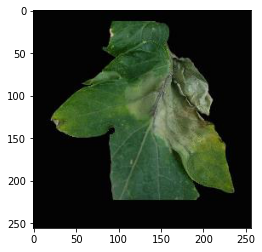

In [ ]:
plt.imshow(x_test[i])
plt.show()